In [98]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import json

from cmdstanpy import CmdStanModel

In [99]:
import arviz as az

In [100]:
data = pd.read_csv('./dataStore/datas_2_ref.csv',index_col=0)

names = {'AlgVLVG0_0Ca_2mgmlcollagen':'Collagen',
        'AlgLVLG15_3Ca_2mgmlcollagen':'IPN soft',
        'AlgVLVG15_22Ca_2mgmlcollagen':'IPN medium',
        'AlgVLVG15_40Ca_2mgmlcollagen':'IPN stiff'}

data['type'] = data['type'].apply(lambda x: names[x])

In [101]:
# create a Boolean mask for the rows to remove
mask = data['type'] == 'IPN stiff'

# select all rows except the ones that contain 'Coca Cola'
data = data[~mask].reset_index(drop=True)
data["size"].astype("int")

0       10
1       10
2       10
3       10
4       10
        ..
1119    30
1120    30
1121    30
1122    30
1123    30
Name: size, Length: 1124, dtype: int32

In [102]:
def _gen_indices(data,names,idx,indices,orig_indices):
    # generate running indices based on the hierarchy
    
    # break recursion if at the end of hierarchy
    if idx>=len(names):
        return indices,orig_indices
    for ii,i in data.groupby(names[idx]):
        counts = i.shape[0]
        latest = 1
        l = indices[names[idx]]
        if len(l) != 0:
            latest = l[-1]+1
        # add running indices to the current level hierarchy
        indices[names[idx]].extend([latest]*counts)
        orig_indices[names[idx]].extend([ii]*counts)
        indices,orig_indices = _gen_indices(i,names,idx+1,indices,orig_indices)
    return indices,orig_indices

def index(name):
    # index vector outside hierarchy
    indices = np.zeros(data.shape[0],dtype=int)
    orig = np.zeros(data.shape[0],dtype=object)
    for idx,i in enumerate(np.unique(data[name])):
        mask = data[name]==i
        indices[mask] = idx
        orig[mask] = i
    return indices,orig

In [103]:
# hierarcical indexing
gnames = ['type','day','sample','holder','location','track_id']
g_indices = {i:[] for i in gnames}
g_orig_indices = {i:[] for i in gnames}

indices,orig_indices = _gen_indices(data,gnames,0,g_indices,g_orig_indices)

# outside hierarchy
size_indices,size_orig = index('size')
coating_indices,coating_orig = index('coating')

In [104]:
# relative scaling
#normalize = lambda x: data[x].sub(data.groupby('type')[x].transform('mean'))\
#             .div(data.groupby('type')[x].transform('std'))

# global scaling
normalize = lambda x: data[x].sub(data.groupby('type')[x].transform('mean'))\
             .div(data[x].std())

# global scaling
normalize = lambda x: data[x].sub(data[x].mean())\
             .div(data[x].std())

data['G_abs_normed'] = normalize('G_abs')
data['phi_normed'] = normalize('phi_(rad)')
data['radius_(m)'] = normalize('radius_(m)')

<Axes: xlabel='type', ylabel='G_abs_normed'>

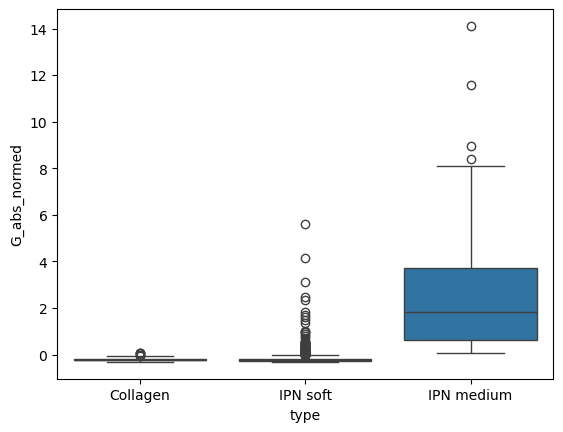

In [105]:
sns.boxplot(data=data,y='G_abs_normed',x='type')

In [143]:
#data_json = {**{f'N_{i}':len(np.unique(j)) for i,j in indices.items()},
#             **{f'{i}_ids':j for i,j in indices.items()},
#             'y':data['G_abs_normed'].tolist(),
#             'N':data.shape[0]}

data_json = {**{f'N_{i}':len(np.unique(j)) for i,j in indices.items()},
             **{f'{i}_ids':j for i,j in indices.items()},
             'size_ids':(size_indices+1).tolist(),
             'N_size':len(np.unique(size_indices)),
             'y':data['G_abs_normed'].tolist(),
             'N':data.shape[0]}

#data_json = {**{f'N_{i}':len(np.unique(j)) for i,j in indices.items()},
#             **{f'{i}_ids':j for i,j in indices.items()},
#             'x_size':data["radius_(m)"].tolist(),
#             'y':data['G_abs_normed'].tolist(),
#             'N':data.shape[0]}
#
with open('./dataStore/data.json','w') as f:
    json.dump(data_json,f)

In [144]:
model = CmdStanModel(stan_file='C:/Users/Arttu/Desktop/Codes/InstruProject/microrheology/model/model_o_size_bin.stan')
fit = model.sample(data='./dataStore/data.json', show_progress=True,adapt_delta=0.99,max_treedepth=15)
print(fit.diagnose())

13:25:29 - cmdstanpy - INFO - compiling stan file C:\Users\Arttu\Desktop\Codes\InstruProject\microrheology\model\model_o_size_bin.stan to exe file C:\Users\Arttu\Desktop\Codes\InstruProject\microrheology\model\model_o_size_bin.exe
13:26:41 - cmdstanpy - INFO - compiled model executable: C:\Users\Arttu\Desktop\Codes\InstruProject\microrheology\model\model_o_size_bin.exe
13:26:42 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:59:55 - cmdstanpy - INFO - CmdStan done processing.


13:59:55 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter[480] is inf, but must be finite! (in 'C:/Users/Arttu/Desktop/Codes/InstruProject/microrheology/model/model_o_size_bin.stan', line 67, column 2 to column 80)
	Exception: normal_lpdf: Location parameter[480] is inf, but must be finite! (in 'C:/Users/Arttu/Desktop/Codes/InstruProject/microrheology/model/model_o_size_bin.stan', line 67, column 2 to column 80)
	Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in 'C:/Users/Arttu/Desktop/Codes/InstruProject/microrheology/model/model_o_size_bin.stan', line 67, column 2 to column 80)
Exception: normal_lpdf: Location parameter[480] is inf, but must be finite! (in 'C:/Users/Arttu/Desktop/Codes/InstruProject/microrheology/model/model_o_size_bin.stan', line 67, column 2 to column 80)
	Exception: normal_lpdf: Location parameter[480] is inf, but must be finite! (in 'C:/Users/Arttu/Desktop/Codes/InstruProject/microrhe

Processing csv files: C:\Users\Arttu\AppData\Local\Temp\tmpt6bz3zcc\model_o_size_bin1lwozlxa\model_o_size_bin-20241029132642_1.csv, C:\Users\Arttu\AppData\Local\Temp\tmpt6bz3zcc\model_o_size_bin1lwozlxa\model_o_size_bin-20241029132642_2.csv, C:\Users\Arttu\AppData\Local\Temp\tmpt6bz3zcc\model_o_size_bin1lwozlxa\model_o_size_bin-20241029132642_3.csv, C:\Users\Arttu\AppData\Local\Temp\tmpt6bz3zcc\model_o_size_bin1lwozlxa\model_o_size_bin-20241029132642_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



In [145]:
az_sample = az.from_cmdstanpy(fit,posterior_predictive='y_hat',
                        log_likelihood='log_likelihood',
                        observed_data={'y':data_json['y']})

In [147]:
vals = fit.draws_pd().filter(regex='^sigma_holder')
vals.columns = ['Collagen','IPN soft', 'IPN medium' ] #,'IPN stiff'

(0.0, 1.0)

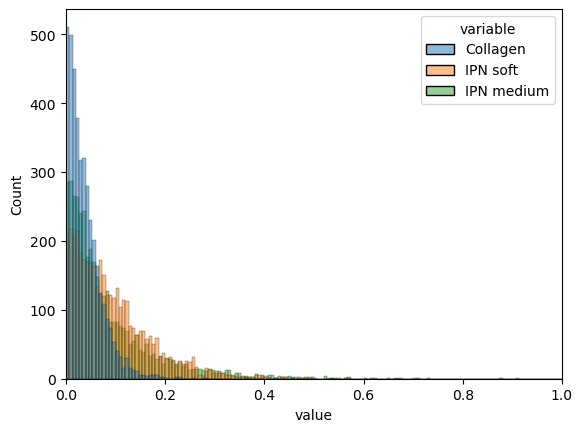

In [148]:
fig,ax = plt.subplots()
sns.histplot(data=vals.melt(),x='value',hue='variable',ax=ax)
ax.set_xlim(0,1)

(0.0, 1.0)

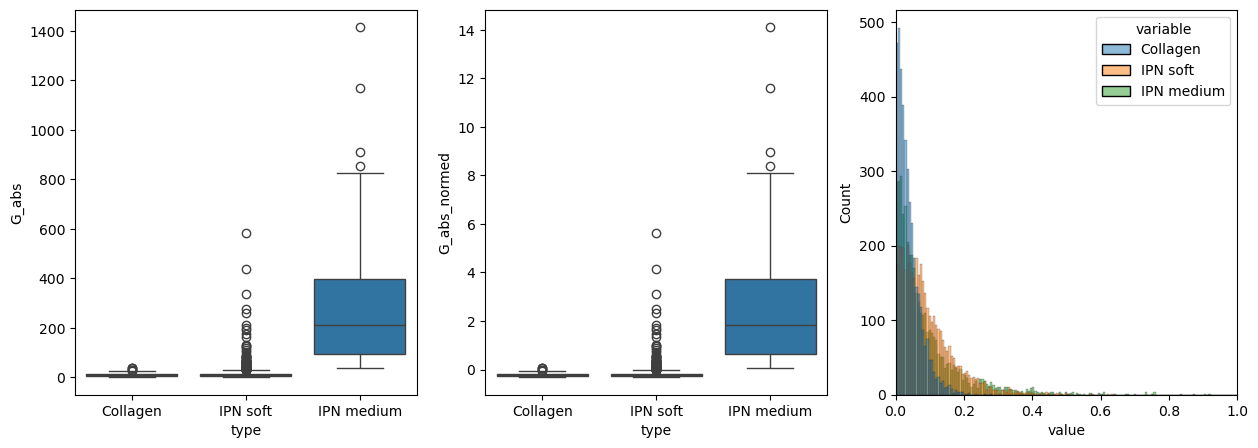

In [73]:
fig,ax = plt.subplots(1,3, figsize = (15,5))

sns.boxplot(data=data,y='G_abs',x='type',ax=ax[0])

sns.boxplot(data=data,y='G_abs_normed',x='type',ax=ax[1])

sns.histplot(data=vals.melt(),x='value',hue='variable',ax=ax[2])
ax[2].set_xlim(0,1)

10um    0.017135
30um    0.057995
50um    0.627960
dtype: float64


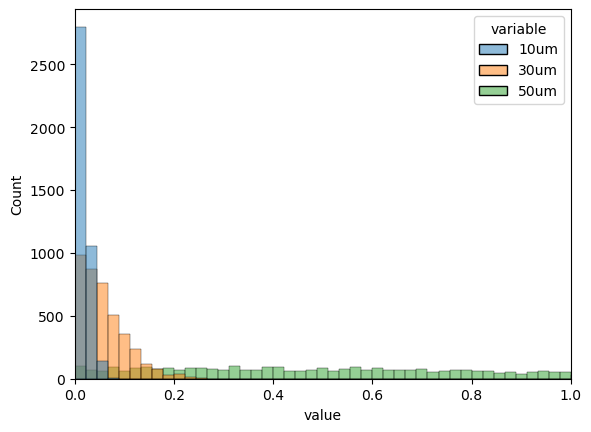

In [146]:
vals = fit.draws_pd().filter(regex='^sigma_size')
vals.columns = ['10um', "30um",'50um' ] #,'IPN stiff'

fig,ax = plt.subplots()
sns.histplot(data=vals.melt(),x='value',hue='variable',ax=ax)
ax.set_xlim(0,1)
print(vals.mean(axis=0))

collagen     -0.016508
IPN_soft      0.045460
IPN medium    0.307893
dtype: float64


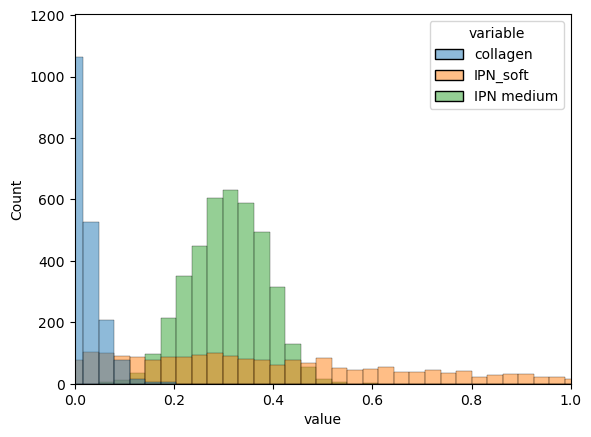

In [142]:
vals = fit.draws_pd().filter(regex='^alpha')
vals.columns = ['collagen', "IPN_soft",'IPN medium' ] #,'IPN stiff'

fig,ax = plt.subplots()
sns.histplot(data=vals.melt(),x='value',hue='variable',ax=ax)
ax.set_xlim(0,1)
print(vals.mean(axis=0))

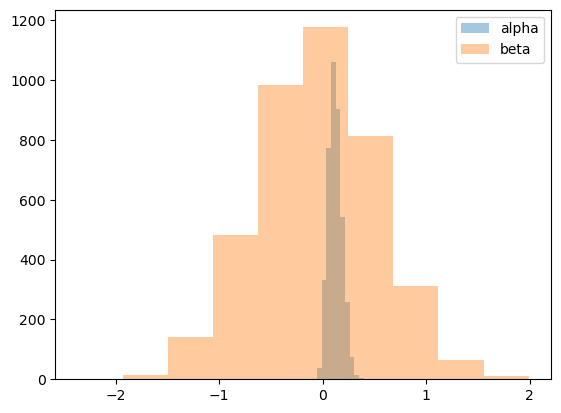

In [134]:
_ = plt.hist(fit.draws_pd().filter(regex='^alpha'), alpha =0.4, label="alpha")
_ = plt.hist(fit.draws_pd().filter(regex='^beta'), alpha =0.4, label="beta")
plt.legend()

In [52]:
track_indices,counts = np.unique(indices['track_id'],return_counts=True)

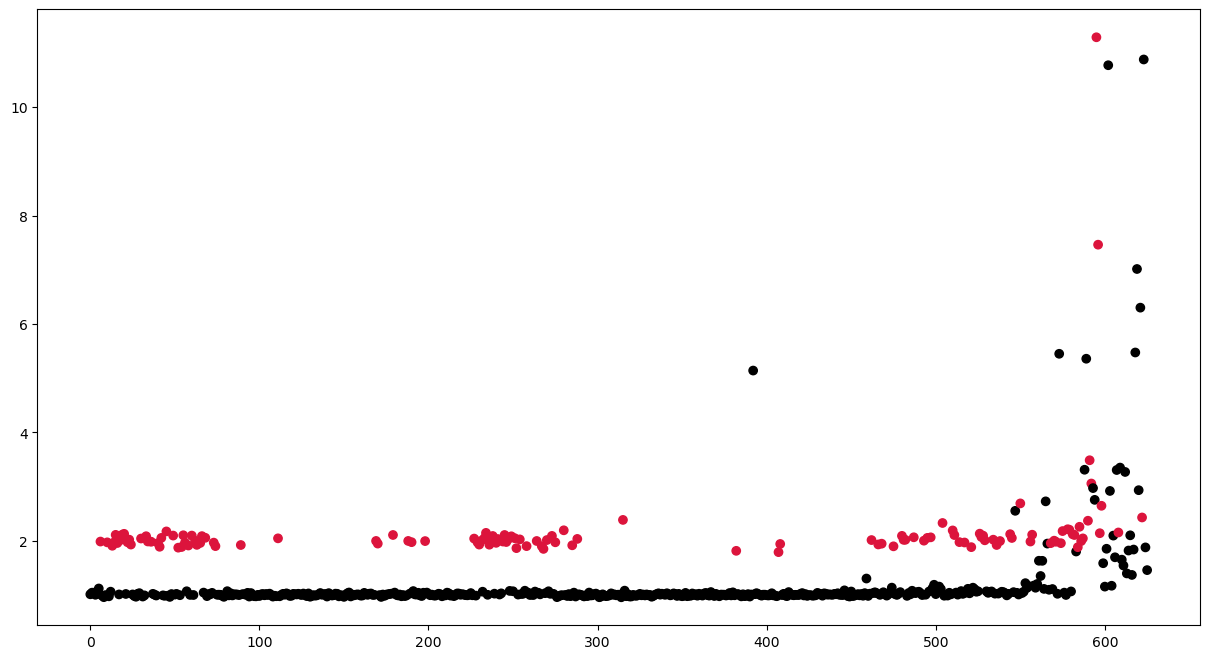

In [53]:
fig = plt.figure(figsize=(15,8))
cols = ['crimson' if i==1 else 'black' for i in counts]
plt.scatter(np.arange(sigmas.shape[1]),sigmas.mean(axis=0).values,c=cols)

In [54]:
print(data.groupby(['type','day','sample','holder','location','track_id'])[['G_abs']].std().to_string())

                                                        G_abs
type       day    sample holder location track_id            
Collagen   211029 10     10     10       0           0.162056
                                         1           5.886139
                                         2           2.722900
                                         3           3.999497
                                         4           1.578650
                                         5           0.655281
           240325 1      1      1        0                NaN
                                         2           0.618805
                                         3           2.262209
                                         4           0.146275
                                         7                NaN
                                         10          2.004349
                                         11          0.988177
                                2        0                NaN
        

In [55]:
np.median(data.groupby(['type','day','sample','holder','location','track_id'])['G_abs'].apply(lambda x: np.nanstd(x)))

0.32984265447842775

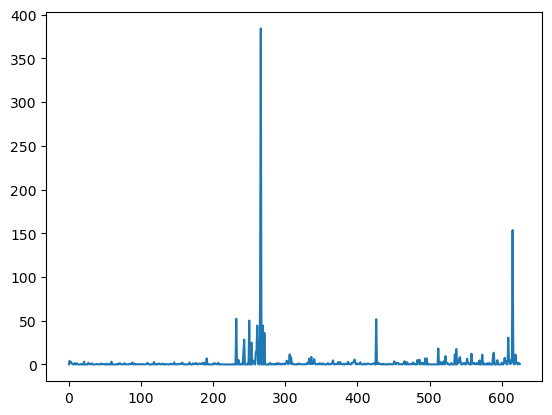

In [56]:
plt.plot(data.groupby(['type','day','sample','holder','location','track_id'])['G_abs'].apply(lambda x: np.nanstd(x)).values)